In [6]:
pacman::p_load(ggplot2,ggpubr,phylotools,geiger,ggtreeExtra,data.table,
               phytools,phyloseq,ggtree,ape,grid,tidyr,wesanderson,
               ggnewscale,stringr,lubridate,ggridges,patchwork,ggstance,dendextend,tidyverse)

In [113]:
tax_table = read.csv(file.path("/vortexfs1/omics/alexander/akrinos/2021-mendota-18S",
                   "MendotaMAGs/eukulele-snake/marmmetspplusjgi/taxonomy-table.txt"), sep="\t")

ref_genome_tree = read.tree(file.path("/vortexfs1/omics/alexander/akrinos/2021-mendota-18S",
                           "MendotaMAGs/BUSCO-MAG-Phylogeny/extracted",
                           "2022-02-08_2/trees/fasttree.nwk"))
ref_tree = as.phylo(ggtree(read.tree(file.path("/vortexfs1/omics/alexander/akrinos/2021-mendota-18S",
                           "MendotaMAGs/BUSCO-MAG-Phylogeny/extracted",
                           "2022-02-08_2/trees/fasttree.nwk"))) + geom_text(aes(label=label)))
new_mag_names = read.csv("../../data/new_mag_names.csv")
data_frame_tree <- as.data.frame(ref_tree %>% fortify() %>% as_tibble()) %>%
    dplyr::left_join(tax_table, by=c("label"="Source_ID")) %>%
    dplyr::left_join(new_mag_names, by=c("label"="bin")) %>%
    dplyr::mutate(NewLab = dplyr::case_when(grepl("bin",label) ~ renamed,
                                            TRUE ~ ""))%>%
    dplyr::mutate(Shape=dplyr::case_when(NewLab %in% c("ME-TYMEFLIES-MAG-32",
                                                            "ME-TYMEFLIES-MAG-38",
                                                            "ME-TYMEFLIES-MAG-37",
                                                            "ME-TYMEFLIES-MAG-43",
                                                            "ME-TYMEFLIES-MAG-42",
                                                            "ME-TYMEFLIES-MAG-46",
                                                            "ME-TYMEFLIES-MAG-36") ~ "hapto_tree",
                                                 NewLab  == "ME-TYMEFLIES-MAG-49" ~ "ochro_tree",
                                                 NewLab %in% c("ME-TYMEFLIES-MAG-47",
                                                           "ME-TYMEFLIES-MAG-48") ~ "chloro_tree",
                                                 TRUE ~ "Other"))

In [58]:
mag_abund_frame = data.frame(fread("../../data/mag_abund_res_90perc_top20.csv"))
metadata_file = read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                                   "meta-lakes/meta-lakes-pipeline/data/all_metadata_12May.csv"))
metadata_file["SampleDate"] = "1900-01-01"
for (curr in 1:nrow(metadata_file)) {
    curr_token = metadata_file$Analysis.Project.Analysis.Project.Name[curr]

    if (grepl("ME", curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "-ME"))
        curr_token = unlist(strsplit(listed_meta[length(listed_meta)], "-"))[1]
        sample_date = curr_token
    }
    if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "D"))
        sample_date = listed_meta[1]
        curr_token = sample_date
        if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {

            listed_meta = unlist(strsplit(curr_token, "s"))
            sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
        } 
    } else if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {
        listed_meta = unlist(strsplit(curr_token, "s"))
        sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
    } else if (!is.na(curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "-"))
        sample_date = trimws(unlist(strsplit(listed_meta[1], "deep"))[1])
    } else {
        sample_date = ""
    }

    if (grepl("Fre",sample_date)) {
        sample_date = "Control"
    }
    if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
        sample_date = unlist(strsplit(sample_date,"D"))[1]

        if (grepl("s", tolower(sample_date)) & !grepl("sep", tolower(sample_date))) {

            sample_date = unlist(strsplit(sample_date, "s"))[1]
        }
        metadata_file$SampleDate[curr] = sample_date
    } else {
        metadata_file$SampleDate[curr] = sample_date
    }


}
mag_abund_frame = mag_abund_frame %>%
    dplyr::left_join(metadata_file)

Joining, by = "SeqProjID"



In [44]:
data_tree_euk <- data.frame(fread(file.path("..","..","data","data_tree_euk.csv")))
distinct_phyla <- sort(c(unique(data_tree_euk$Phylum),c("Bacterial")))
phylum_distinct_cols <- c('#e6194b', '#3cb44b', '#ffe119', '#4363d8', 'gray', '#911eb4', 
                   '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
                   '#9a6324', '#fffac8', '#800000', '#aaffc3', 
                   '#808000', '#ffd8b1', '#000075', '#808080')#, '#ffffff', '#000000')

In [45]:
eukulele_dir = file.path("/vortexfs1/omics/alexander/akrinos/2021-mendota-18S/",
               "MendotaMAGs/eukulele-21Dec-complete/max_level_mags")


In [46]:
all_frame = data.frame()
for (curr_file in list.files(eukulele_dir)) {
    curr_frame = read.csv(file.path(eukulele_dir,curr_file),sep="\t") %>%
        dplyr::rename(c("Level"="X", "Taxon"="max_taxa", "PercentID"="percent_id")) %>%
        dplyr::mutate("MAG" = unlist(strsplit(curr_file,"-max"))[1])
    if (((curr_frame %>% dplyr::filter(Level == "domain"))$Taxon == "Bacteria") | 
        ( unlist(strsplit(curr_file,"-max"))[1]== "ME-TYMEFLIES-MAG-14")) {
        next
    }
    all_frame = all_frame %>% dplyr::bind_rows(curr_frame)
}

In [108]:
all_frame = all_frame%>%dplyr::mutate(Shape=dplyr::case_when(MAG %in% c("ME-TYMEFLIES-MAG-32",
                                                            "ME-TYMEFLIES-MAG-38",
                                                            "ME-TYMEFLIES-MAG-37",
                                                            "ME-TYMEFLIES-MAG-43",
                                                            "ME-TYMEFLIES-MAG-42",
                                                            "ME-TYMEFLIES-MAG-46",
                                                            "ME-TYMEFLIES-MAG-36") ~ "hapto_tree",
                                                 MAG  == "ME-TYMEFLIES-MAG-49" ~ "ochro_tree",
                                                 MAG %in% c("ME-TYMEFLIES-MAG-47",
                                                           "ME-TYMEFLIES-MAG-48") ~ "chloro_tree",
                                                 TRUE ~ "Other"))

Warning message:
“Using size for a discrete variable is not advised.”
Warning message:
“Removed 49 rows containing missing values (geom_point).”


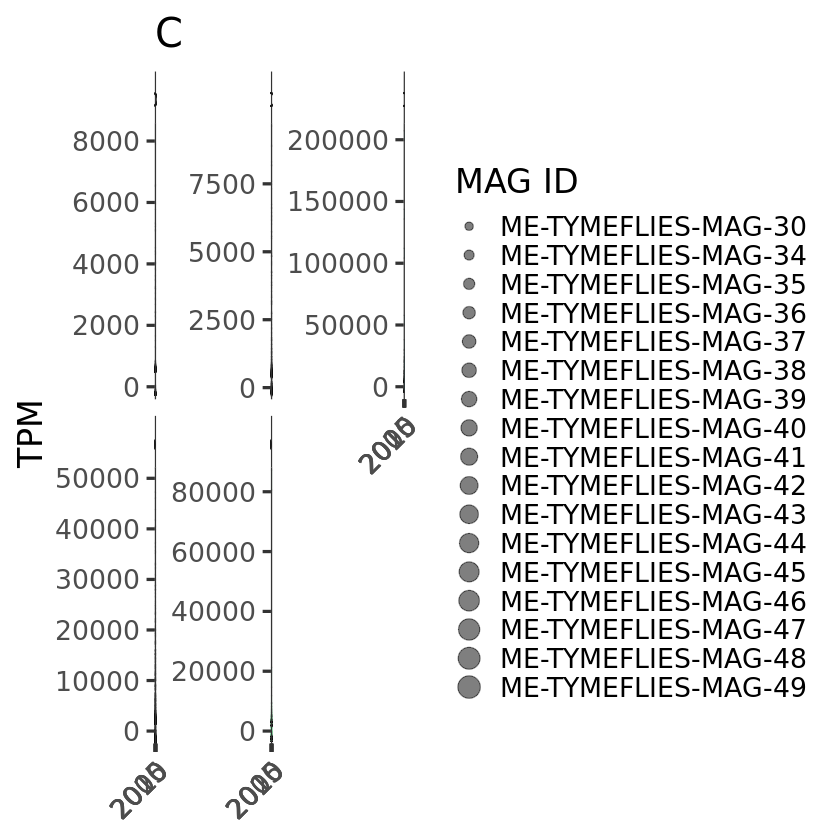

In [117]:
mag_abund_plot = ggplot(mag_abund_frame %>% dplyr::left_join(all_frame%>%dplyr::filter(Level=="division")%>%
                                            dplyr::rename(c("Division"="Taxon")),by="MAG")) + 
    geom_point(aes(x=as.Date(SampleDate,format="%d%b%Y"),y=TPM,fill=Division,size=factor(MAG),
                   shape=Shape),alpha=0.5) + 
    facet_wrap(~Division,ncol=3,scales="free_y") + 
    scale_shape_manual(name="Type",breaks=c("ochro_tree","hapto_tree","chloro_tree","Other"),
                      values=c(22,23,24,21)) + 
    theme_bw(base_size=20)+scale_size_discrete(name="MAG ID") + 
    scale_fill_manual(values=distinct_cols, breaks=order_phyla,name="Taxon", 
                      na.value="transparent", na.translate = F) + xlab("Date") + 
    theme(axis.title.x = element_blank())+
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))+
    guides(fill="none",shape="none") + ggtitle("C")
mag_abund_plot

In [50]:
which(order_phyla=="Dinoflagellata")
distinct_cols[which(order_phyla=="Dinoflagellata")]

[1] 21

[1] "red"

Warning message:
“Removed 154 rows containing missing values (geom_point).”
Warning message:
“Removed 154 rows containing missing values (geom_point).”
Warning message:
“Removed 154 rows containing missing values (geom_segment).”
Warning message:
“Removed 154 rows containing missing values (geom_point).”
Warning message:
“Removed 154 rows containing missing values (geom_point).”
Warning message:
“Removed 154 rows containing missing values (geom_segment).”


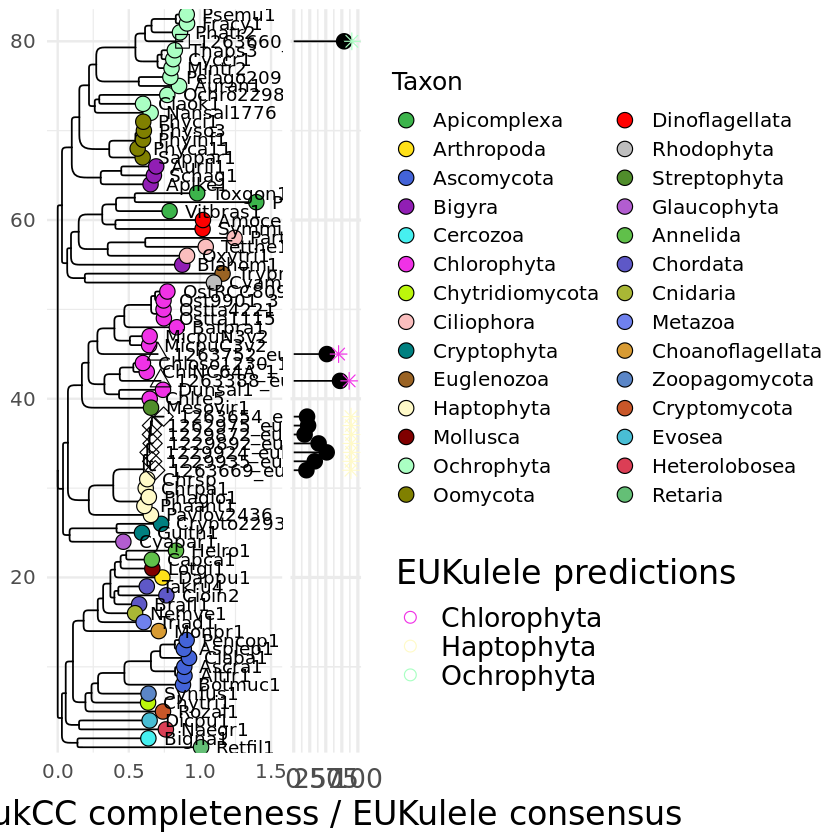

In [130]:
library(aplot)
order_phyla = na.omit(unique((data_frame_tree %>% dplyr::arrange(desc(y)))$Division))
order_phyla = c(distinct_phyla, setdiff(order_phyla,distinct_phyla))
distinct_cols=c(phylum_distinct_cols,setdiff(c("red","grey","#508d2b","#b25dd0","#60c04a",
                "#5e58c7","#a9b735","#6f81ee",
                "#d89b33","#5b86c7","#c95729",
                "#49bed5","#db3e55","#64bf76","#d4459b","#408349",
                "#82519a","#757922","#bc8dd8","#b5af62","#a1476f",
                "#5cc09f","#a84748","#2f846a","#dd82b2","#69773d","#e17d7d",
                "#93682f","#dd9667"),phylum_distinct_cols))
tree_plot = (ggtree(data_frame_tree,layout="roundrect") + 
    geom_tippoint(aes(fill=factor(Division,levels=order_phyla),shape=Shape), size=4) + 
    scale_fill_manual(values=distinct_cols, breaks=order_phyla, name="Taxon", 
                      na.value="transparent", na.translate = F) + 
    theme_minimal(base_size=20) + 
    scale_shape_manual(name="Type",breaks=c("ochro_tree","hapto_tree","chloro_tree","Other"),
                      values=c(22,23,24,21)) + 
    geom_tiplab(aes(label=NewLab), offset=0.1)) + guides(shape="none",
                                                         fill = guide_legend(override.aes=list(shape = 21)))

lollipop_plot = ggplot(data_frame_tree %>% 
                     dplyr::left_join(all_frame %>% dplyr::filter(Level == "division"), 
                                      by = c("NewLab"="MAG")) %>%
                     dplyr::mutate(PercentID = PercentID*100)) + 
              geom_point(aes(y = y, 
                            x = completeness)
                        ,size=4,stat="identity") +
              geom_point(aes(x=PercentID, y=y, color=Taxon), 
                         pch=8,size=5) + 
    theme_minimal(base_size=15) + xlim(0,100) +
    scale_color_manual(breaks=order_phyla, values = distinct_cols, name = "EUKulele predictions") + 
    theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) + 
    geom_segment(aes(x = 0, xend = completeness, y = y,yend=y))+ xlab("EukCC completeness / EUKulele consensus")

tree_mags = (ggtree(data_frame_tree,layout="roundrect") + 
    geom_tippoint(aes(fill=factor(Division,levels=order_phyla),shape=Shape), size=4) + 
    scale_fill_manual(values=distinct_cols, breaks=order_phyla,name="Taxon", 
                      na.value="transparent", na.translate = F) + 
    theme_minimal(base_size=15) +
    scale_shape_manual(name="Type",breaks=c("ochro_tree","hapto_tree","chloro_tree","Other"),
                      values=c(22,23,24,21),labels=c("Ochrophyte MAGs","Haptophyte MAGs","Chlorophyte MAGs",
                                                     "Other")) + guides(shape="none",
                                                                       fill = guide_legend(override.aes=list(shape = 21))) + 
    geom_tiplab(aes(label=label), offset=0.1)) %>% insert_right((ggplot(data_frame_tree %>% 
                                                                         dplyr::left_join(all_frame %>% dplyr::filter(Level == "division"), 
                                                                                          by = c("NewLab"="MAG")) %>%
                                                                         dplyr::mutate(PercentID = PercentID*100)) + 
                                                                  geom_point(aes(y = y, 
                                                                                x = completeness)
                                                                            ,size=4,stat="identity") +
                                                                  geom_point(aes(x=PercentID, y=y, color=Taxon), 
                                                                             pch=8,size=3) + 
    theme_minimal(base_size=20) + xlim(0,100) +
    scale_color_manual(breaks=order_phyla, values = distinct_cols, name = "EUKulele predictions")) + 
    theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) + guides(shape="none",
                                             color = guide_legend(override.aes=list(shape = 21))) + 
    geom_segment(aes(x = 0, xend = completeness, y = y,yend=y))+ xlab("EukCC completeness / EUKulele consensus"),width=0.3)
tree_mags
ggsave("tree-check.png",width=15,height=3,units="in")

In [128]:
summarized_info

Taxon,Division,MaxCompleteness,NumberMAGs
<chr>,<chr>,<dbl>,<int>
Bacillariophyta,Ochrophyta,78.60,2
Bicoecea,Ochrophyta,18.99,2
Colpodea,Ciliophora,38.96,3
Cryptophyceae,Cryptophyta,17.65,2
Dinophyceae,Dinoflagellata,5.88,1
Dinophyceae,Ochrophyta,32.04,6
Mamiellophyceae,Chlorophyta,81.45,4
Prymnesiophyceae,Haptophyta,51.40,9
Spirotrichea,Ciliophora,10.64,4


Joining, by = "MAG"

`summarise()` has grouped output by 'Taxon'. You can override using the `.groups` argument.



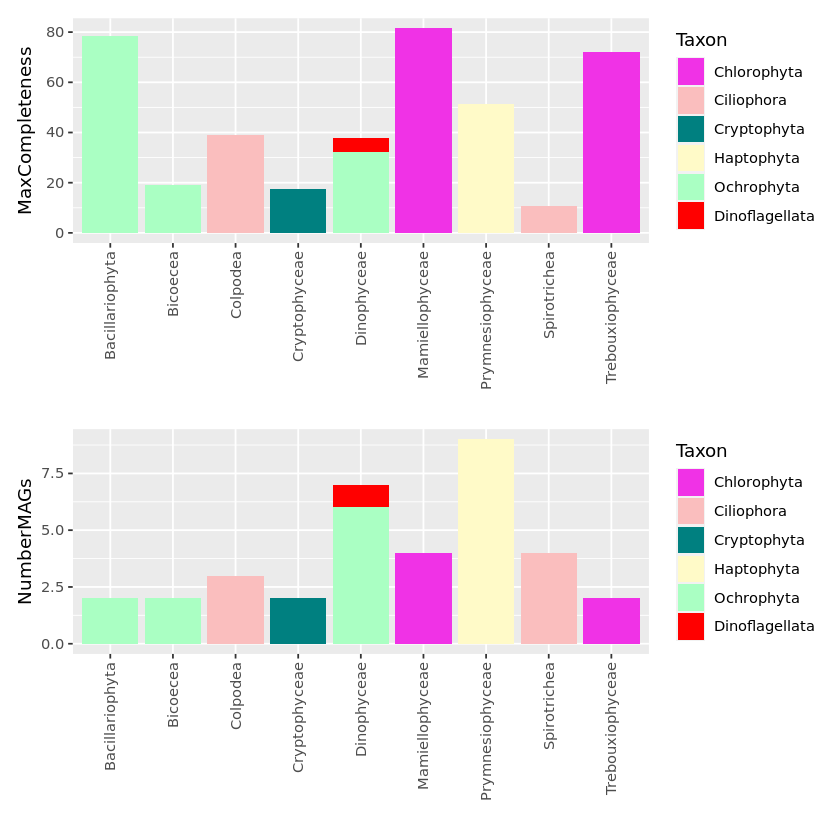

In [122]:
summarized_info = all_frame %>% dplyr::filter(Level == "class") %>% 
    dplyr::left_join(all_frame %>% dplyr::filter(Level == "division") %>%
                     dplyr::select(Taxon,MAG) %>% dplyr::rename(c("Division"="Taxon"))) %>%
    dplyr::left_join(new_mag_names,by=c("MAG"="renamed")) %>%
    dplyr::group_by(Taxon,Division) %>% dplyr::summarize(MaxCompleteness = max(completeness),
                                                NumberMAGs = dplyr::n())

(ggplot(summarized_info) + geom_bar(aes(x = Taxon, y = MaxCompleteness,fill=Division),stat="identity")+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + xlab("")+
    scale_fill_manual(breaks=order_phyla, values = distinct_cols, name = "Taxon")) /
(ggplot(summarized_info) + geom_bar(aes(x = Taxon, y = NumberMAGs,fill=Division),stat="identity")+
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + xlab("")+
    scale_fill_manual(breaks=order_phyla, values = distinct_cols, name = "Taxon"))

In [123]:
MAG_completeness = ((ggplot(summarized_info) + geom_bar(aes(x = Taxon, y = MaxCompleteness,
                                                           fill=Division),stat="identity",
                                        color = "black")+
     theme_bw(base_size=20) +
     scale_fill_manual(breaks=order_phyla, values = distinct_cols, name = "Taxon")+
     theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + xlab("") + 
     ggtitle("D")+ theme(legend.position="none") + 
                     #theme(axis.title.x=element_blank(),
        #axis.text.x=element_blank(),
        #axis.ticks.x=element_blank()) + 
                     ylab("Maximum completeness (%)"))  | 
(ggplot(summarized_info) + geom_bar(aes(x = Taxon, y = NumberMAGs,fill=Division),
                                    stat="identity",color = "black")+ theme_bw(base_size=20) + 
    ylab("Number of MAGs") +theme(legend.position="none") + 
    scale_fill_manual(breaks=order_phyla, values = distinct_cols, name = "Taxon") + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + xlab("") + ggtitle("E")))

In [124]:
combined_plot1 = (tree_plot | lollipop_plot + ylim2(tree_plot)) + 
    plot_layout(guides = 'collect',widths=c(1,0.5))

Warning message:
“Removed 154 rows containing missing values (geom_point).”
Warning message:
“Removed 154 rows containing missing values (geom_point).”
Warning message:
“Removed 154 rows containing missing values (geom_segment).”
ERROR while rich displaying an object: Error in grid.Call.graphics(C_xspline, x$x, x$y, x$shape, x$open, x$arrow, : non-finite control point in Xspline

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         st

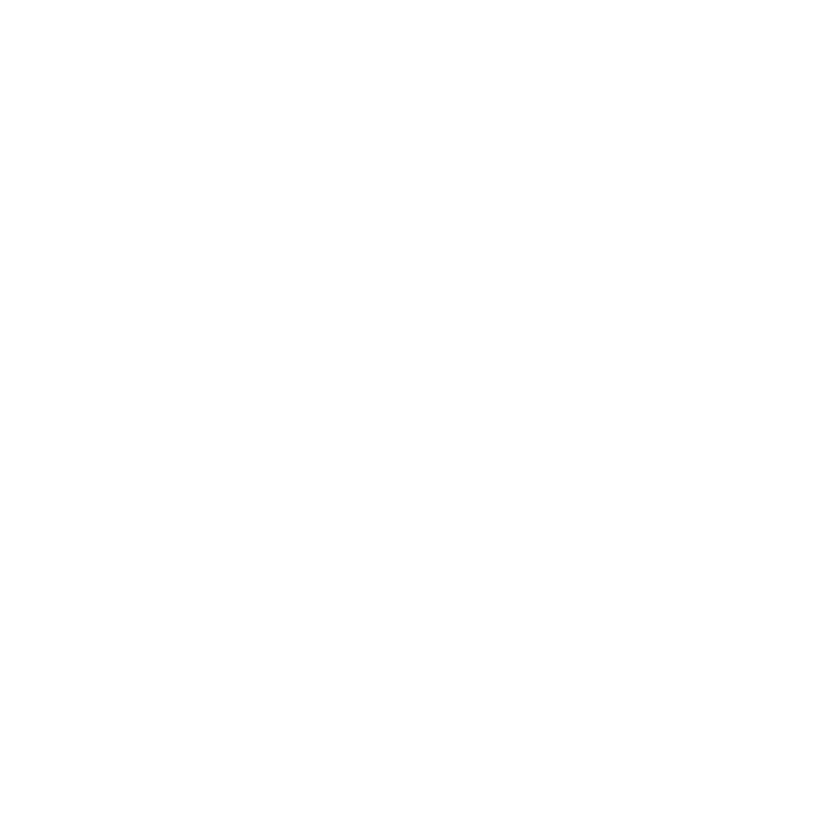

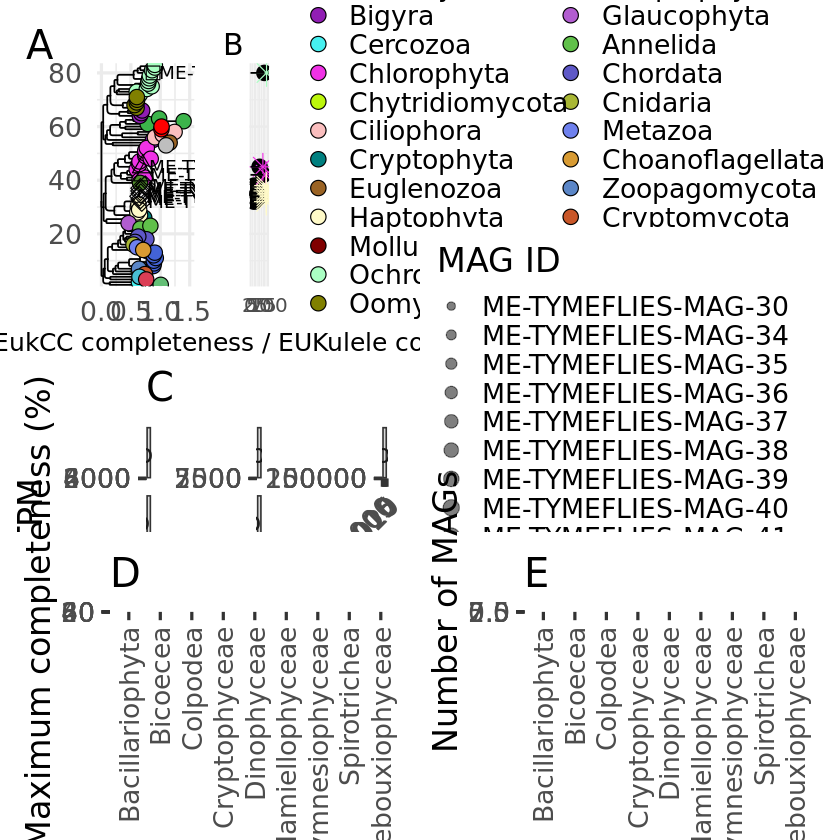

In [132]:
combo_1 = (tree_plot | (lollipop_plot + ylim2(tree_plot))) + plot_annotation(tag_levels = 'A') +
    plot_layout(guides = 'collect',widths=c(4,0.8))

((tree_plot | lollipop_plot + ylim2(tree_plot)) / MAG_completeness)+ 
    theme(legend.position = 'bottom') + 
    plot_layout(guides = 'collect',heights=c(1,0.2),widths=c(4,0.5)) &
    theme(legend.position = 'bottom') & plot_annotation(tag_levels = 'A') 
cowplot::plot_grid(combo_1, mag_abund_plot, MAG_completeness, ncol = 1, rel_heights = c(1,0.6,0.6))
ggsave("../../figures/mendota_mag_plot.pdf",dpi=400,width=22,height=22,units="in") 

Warning message:
“Removed 154 rows containing missing values (geom_point).”
Warning message:
“Removed 154 rows containing missing values (geom_point).”
Warning message:
“Removed 154 rows containing missing values (geom_segment).”


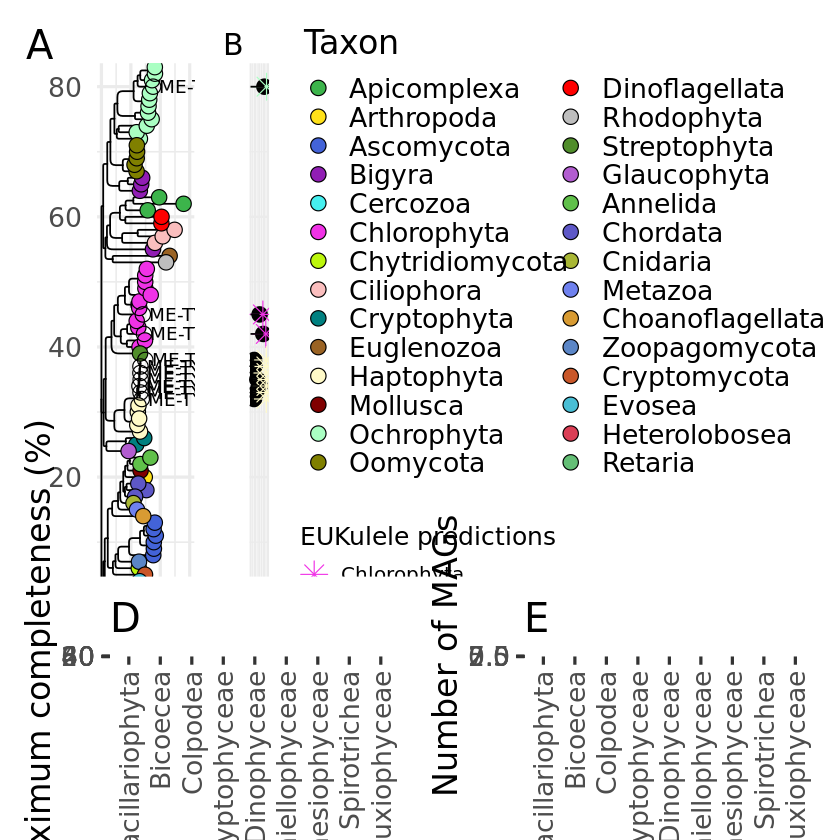

In [103]:
cowplot::plot_grid(combo_1, MAG_completeness, ncol = 1, rel_heights = c(1,0.2))